In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [30]:
from read_mist_models import ISO

In [15]:
fp = '../Data/NGC3532-result.fits'
# df = pd.read_csv(fp, header=None)
df = Table.read(fp, format='fits').to_pandas()

In [32]:
iso = ISO('../Data/MIST_iso_HW2.iso')

Reading in: ../Data/MIST_iso_HW2.iso


In [ ]:
parallax = df['parallax']

# d = 1000 / parallax (milli-arcseconds)
d = 1000 / parallax

g_mean_mag = df['phot_g_mean_mag'] # in apparent magnitude
bp_rp = df['bp_rp'] # in magnitude

# convert to absolute magnitude
g_abs_mag = g_mean_mag - 5 * np.log10(d) + 5

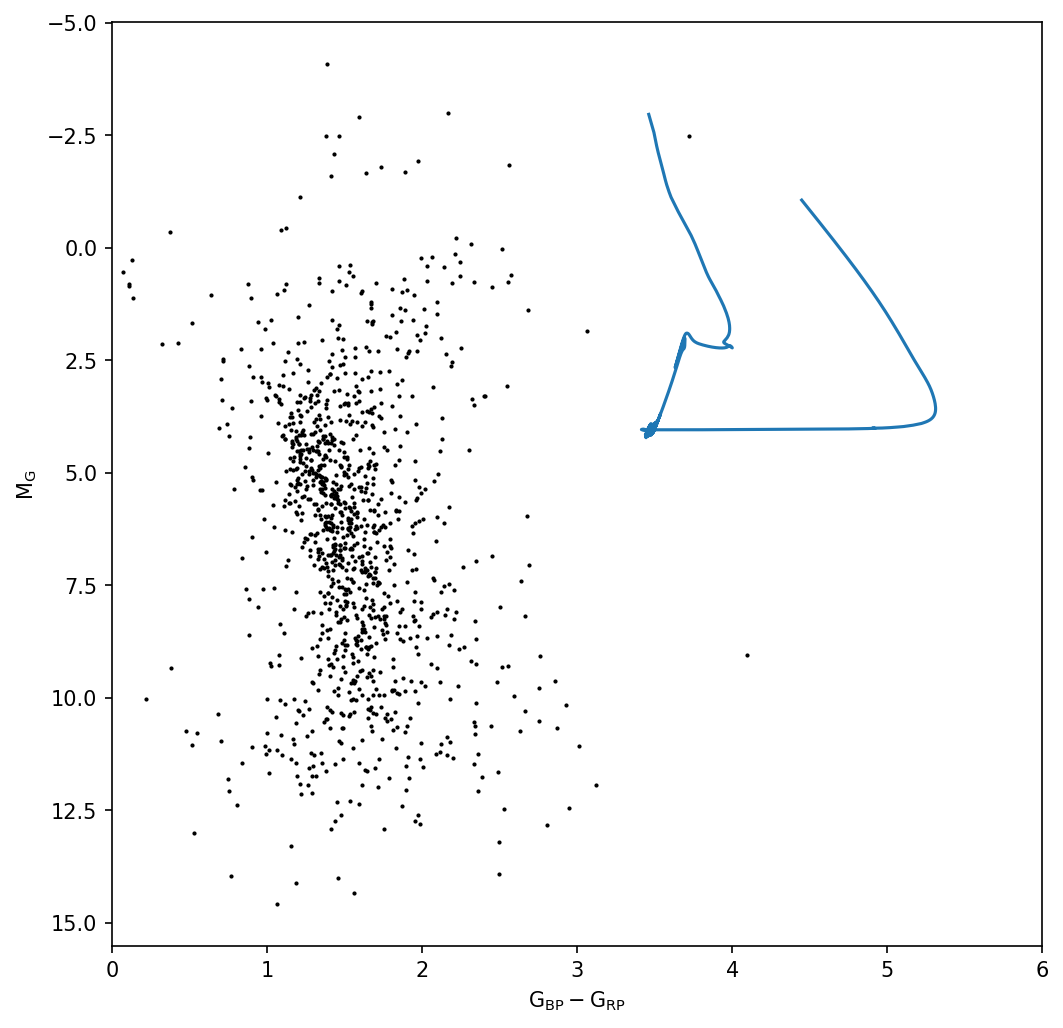

In [49]:
fig, ax = plt.subplots(dpi=150, figsize=(8, 8))

# # Plot the data
ax.scatter(bp_rp, g_abs_mag, s=1, color='black')

age_ind = iso.age_index(8.60) #returns the index for the desired age
logTeff = iso.isos[age_ind]['log_Teff']
logL = iso.isos[age_ind]['log_L']
plt.plot(logTeff, logL) 
# plt.xlabel('log(Teff)')
# plt.ylabel('log(L)')


ax.invert_yaxis()
ax.set_xlim(0, 6)

# Set labels
ax.set_xlabel(r'$\rm{G_{BP} - G_{RP}}$')
ax.set_ylabel(r'$\rm{M_G}$')

# plt.title('Scatter Plot with Square Root of Relative Density')
# plt.show()
plt.savefig('ASTR-400A-HWs/figs/HRD.png', dpi=150, bbox_inches='tight')
